In [1]:
# Using all_data_retention.xlsx saved as a .csv
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb
from seaborn import heatmap
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
import re

In [2]:
SEED = 42

# Read in data and format columns
df = pd.read_csv("all_data_retention.csv")
df.columns = [x.replace("\n","").strip() for x in df.columns.tolist()]

# Rename Columns from Survey Questions to smaller Variable names
df.rename(columns = {'Not including your children under 18, how many other family members live with you (including spouse/partner, parents, etc.)':'Amt_AdultsinFamily',
                     "How many children under age 18 do you have, who live at home with you":"Amt_childreninFamily",
                    "Is your spouse/partner one of those who live with you":"SpouseorPartner_atHome",
                    "Who is the family's primary income earner":"primaryIncomeOwner",
                    "How much money did the other family members who live with you (children, spouse, others) contribute to your family's income LAST MONTH":"moneyLastMonth_fromFamilyatHome",
                    "How much did your family receive in WIC, SNAP/Food Stamps, Social Security, Unemployment Insurance, Medicaid, Housing Assistance, other government benefits LAST MONTH":"moneyLastMonth_fromGovBenefits",
                    "What was YOUR contribution to the family's income LAST MONTH": "moneyLastMonth_fromYou",
                    "Which best describes your housing situation":"housingSituation",
                    "What is the MONTHLY cost of your housing":"costofHousing_Monthly",
                    "Do you have a car": "car",
                    "Have a computer": "computer",
                    "Do you sell items or provide services to earn money on your own? That is, do you work for yourself (e.g. cooking, babysitting, selling cosmetics)": "ProvideServices_workForYourself",
                    "What is the primary location that you sell or provide these services": "location_ofsellingServices",
                    "Country of Birth (Member)":"Country_ofBirth_Member",
                    "Have you ever had a CHECKING account with a bank in the United States":"CheckingAccount_inUS",
                    "What is the current balance in this CHECKING account": "CheckingAcount_balance",
                    "Have you ever had a SAVINGS account with a bank in the United States":"SavingsAccount_inUS",
                    "What is the current balance in this SAVINGS account":"SavingsAccount_balance",
                    "Have you ever had a credit card":"own_creditCard",
                    "What was or is the rate of interest (APR) charged on this credit card %":"APR_onCreditCard",
                    "Card ID Number (PUID) (Member)":"CardIDNumber_PUID_Member",
                     "Reason for Blacklist (Member)": "BlackListReason_Member",
                     "Reason For Departure (Why did the Member leave?)":"DepartureReason_Member",
                     "Select Business Category":"BusinessCategory",
                     "Which of the following best describes what you intend to use this Grameen loan for":"intention_forGrameenLoan",
                     "Is this your first Grameen America loan / Es tu primer préstamo con Grameen America?":"isthis_FirstGrameenLoan",
                     "Were you running this business or income generating activity before receiving this Grameen America loan":"runningBusiness_beforeGrameenLoan",
                     "How many hours a week do you work at your Grameen business or income generating activity":"hoursWorkEveryWeek_GrameenBusiness",
                     "What is your average MONTHLY income from your Grameen business or income generating activity":"monthlyIncome_GrameenActivity",
                     "What is the primary location where you operate your Grameen America business":"location_GrameenBusiness",
                     "NOT including yourself, how many full-time employees (employees working MORE than 30 hours per week) do you pay":"fullTimeEmployees_toPay",
                     "NOT including yourself, how many part-time employees (employees working LESS than 30 hours per week) do you pay": "partTimeEmployees_toPay",
                     "Which of the following best describes your ethnicity":"yourEthinicity",
                     "Which of the following best describes your race": "YourRace",
                     "Do you have a wage-earning job (NOT your Grameen activity)": "havewageEarningJob_notGrameenActivity",
                     "Which of the following best describes your wage-earning job (NOT your Grameen activity)":"wageEarningJob_notGrameenActivity",
                     "How many hours per WEEK do you work at this wage-earning job":"hoursWeekly_wageEarningJob_notGrameenActivity",
                     "What is your total MONTHLY income from this wage earning job / Cual es tu ingreso total MENSUAL de este trabajo asalariado?":"monthlyIncome_wageEarningJob_notGrameenActivity",
                     "In the last week, how many times did you use your debit/ATM card to pay for some item (such as groceries, business purchases, phone bills, electricity bills, etc.)?":"timesUsed_debitOrATMcard",
                     "Phone Provider":"PhoneProvider"
                    }, inplace = True) 

/home/nithi/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (33,42,43) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#Drop Rows in which the Account IDs don't match
ID_noMatch_indexes = df[df["Match?"]!=1.0].index
df.drop(ID_noMatch_indexes, inplace = True)

# Obtain the Amount of members in the family
df["Amt_AdultsinFamily"].replace("0 (None/Ninguno)", 0, inplace=True)
df["Amt_AdultsinFamily"].replace("9 or more / 9 o más", 10, inplace=True)
df["Amt_AdultsinFamily"] = pd.to_numeric(df["Amt_AdultsinFamily"])
df["Amt_childreninFamily"].replace("0 (None/Ninguno)", 0, inplace=True)
df["Amt_childreninFamily"].replace("9 or more / 9 o más", 10, inplace=True)
df["Amt_childreninFamily"] = pd.to_numeric(df["Amt_childreninFamily"])
df["FamilySize"] = df["Amt_childreninFamily"]  + df["Amt_AdultsinFamily"]

# Columns chosen on what could predict Retention
# df = df[['Branch', 'Account Holder ID', 'Account Holder ID2',
#        'Account ID', 'FamilySize',
#        'SpouseorPartner_atHome', 'primaryIncomeOwner',
#        'moneyLastMonth_fromFamilyatHome', 
#          'moneyLastMonth_fromGovBenefits',
#        'moneyLastMonth_fromYou', 'housingSituation', 
#          'costofHousing_Monthly',
#        'car', 'ProvideServices_workForYourself',
#        'location_ofsellingServices',
#        'CheckingAcount_balance', 
#        'SavingsAccount_balance', 'BusinessCategory',
#        'runningBusiness_beforeGrameenLoan',
#        'hoursWorkEveryWeek_GrameenBusiness', 'monthlyIncome_GrameenActivity',
#        'location_GrameenBusiness', 'fullTimeEmployees_toPay',
#        'partTimeEmployees_toPay', 'yourEthinicity', 'YourRace',
#        'havewageEarningJob_notGrameenActivity',
#        'wageEarningJob_notGrameenActivity',
#        'hoursWeekly_wageEarningJob_notGrameenActivity',
#        'monthlyIncome_wageEarningJob_notGrameenActivity',
#         'retention_1','retention_2', 'retention_3',  ]]

#select continuous columns
df = df[['FamilySize','SpouseorPartner_atHome', 'primaryIncomeOwner',
       'moneyLastMonth_fromFamilyatHome', 
       'moneyLastMonth_fromGovBenefits',
       'moneyLastMonth_fromYou',
       'costofHousing_Monthly',
       'car', 'ProvideServices_workForYourself',
       'CheckingAcount_balance', 
       'SavingsAccount_balance', 
       'runningBusiness_beforeGrameenLoan',
       'hoursWorkEveryWeek_GrameenBusiness', 
       'monthlyIncome_GrameenActivity',
       'fullTimeEmployees_toPay',
       'partTimeEmployees_toPay',
       'havewageEarningJob_notGrameenActivity',
       'hoursWeekly_wageEarningJob_notGrameenActivity',
       'monthlyIncome_wageEarningJob_notGrameenActivity',
       'retention_1','retention_2', 'retention_3',  ]]
df.fillna(0, inplace = True)

df["havewageEarningJob_notGrameenActivity"].replace("Yes / Si", 1, inplace=True)
df["havewageEarningJob_notGrameenActivity"].replace("No", 0, inplace=True)
df["ProvideServices_workForYourself"].replace("Yes / Si", 1, inplace=True)
df["ProvideServices_workForYourself"].replace("No", 0, inplace=True)

df["car"].replace("Yes / Si", 1, inplace=True)
df["car"].replace("No", 0, inplace=True)

df["SpouseorPartner_atHome"].replace("No - I am single", 0, inplace=True)
df["SpouseorPartner_atHome"].replace("No - I am a widow", 0, inplace=True)
df["SpouseorPartner_atHome"].replace("No - I am divorced", 0, inplace=True)
df["SpouseorPartner_atHome"].replace("No - I am married but my spouse/partner does not live with me", 0, inplace=True)
df["SpouseorPartner_atHome"].replace("Prefer not to answer", 0, inplace=True)
df["SpouseorPartner_atHome"].replace("Yes - My spouse/partner lives with me", 1, inplace=True)

df["primaryIncomeOwner"].replace("Other Relative", 0, inplace=True)
df["primaryIncomeOwner"].replace("Other", 0, inplace=True)
df["primaryIncomeOwner"].replace("Spouse/partner", 0, inplace=True)
df["primaryIncomeOwner"].replace("Child", 0, inplace=True)
df["primaryIncomeOwner"].replace("Myself", 1, inplace=True)

df["runningBusiness_beforeGrameenLoan"].replace("No, it is a new business or income-generating activity / No, es un nuevo negocio o actividad", 0, inplace=True)
df["runningBusiness_beforeGrameenLoan"].replace("Yes, I was running it before / Si, ya lo manejaba", 1, inplace=True)

#if there is a range it finds the mean of the range
# df = df.apply(lambda x: np.mean(list(map(int, re.findall(r'[0-9]+', str(x))) )))

df['moneyLastMonth_fromFamilyatHome'] = df['moneyLastMonth_fromFamilyatHome'].apply(lambda x: np.mean(list(map(int, re.findall(r'[0-9]+', str(x))) )))
df['moneyLastMonth_fromGovBenefits'] = df['moneyLastMonth_fromGovBenefits'].apply(lambda x: np.mean(list(map(int, re.findall(r'[0-9]+', str(x))) )))
df["moneyLastMonth_fromYou"] = df["moneyLastMonth_fromYou"].apply(lambda x: np.mean(list(map(int, re.findall(r'[0-9]+', str(x))) ))) 
df["costofHousing_Monthly"] = df["costofHousing_Monthly"].apply(lambda x: np.mean(list(map(int, re.findall(r'[0-9]+', str(x))) ))) 
df["CheckingAcount_balance"] = df["CheckingAcount_balance"].apply(lambda x: np.mean(list(map(int, re.findall(r'[0-9]+', str(x))) ))) 
df["SavingsAccount_balance"] = df["SavingsAccount_balance"].apply(lambda x: np.mean(list(map(int, re.findall(r'[0-9]+', str(x))) ))) 
df["hoursWorkEveryWeek_GrameenBusiness"] = df["hoursWorkEveryWeek_GrameenBusiness"].apply(lambda x: np.mean(list(map(int, re.findall(r'[0-9]+', str(x))) ))) 
df["monthlyIncome_GrameenActivity"] = df["monthlyIncome_GrameenActivity"].apply(lambda x: np.mean(list(map(int, re.findall(r'[0-9]+', str(x))) ))) 
df["fullTimeEmployees_toPay"] = df["fullTimeEmployees_toPay"].apply(lambda x: np.mean(list(map(int, re.findall(r'[0-9]+', str(x))) ))) 
df["partTimeEmployees_toPay"] = df["partTimeEmployees_toPay"].apply(lambda x: np.mean(list(map(int, re.findall(r'[0-9]+', str(x))) ))) 
df["hoursWeekly_wageEarningJob_notGrameenActivity"] = df["hoursWeekly_wageEarningJob_notGrameenActivity"].apply(lambda x: np.mean(list(map(int, re.findall(r'[0-9]+', str(x))) ))) 
df["monthlyIncome_wageEarningJob_notGrameenActivity"] = df["monthlyIncome_wageEarningJob_notGrameenActivity"].apply(lambda x: np.mean(list(map(int, re.findall(r'[0-9]+', str(x))) ))) 

with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    display(df)

,FamilySize,SpouseorPartner_atHome,primaryIncomeOwner,moneyLastMonth_fromFamilyatHome,moneyLastMonth_fromGovBenefits,moneyLastMonth_fromYou,costofHousing_Monthly,car,ProvideServices_workForYourself,CheckingAcount_balance,SavingsAccount_balance,runningBusiness_beforeGrameenLoan,hoursWorkEveryWeek_GrameenBusiness,monthlyIncome_GrameenActivity,fullTimeEmployees_toPay,partTimeEmployees_toPay,havewageEarningJob_notGrameenActivity,hoursWeekly_wageEarningJob_notGrameenActivity,monthlyIncome_wageEarningJob_notGrameenActivity,retention_1,retention_2,retention_3
0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,1,25.5,1900.5,0.0,0.0,0,0.0,0.0,0,1,2
1,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,1,15.5,1100.5,0.0,0.0,0,0.0,0.0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98469,2.0,1,0,300.5,500.5,300.5,100.5,1,1,125.0,125.0,1,35.5,700.5,0.0,0.0,0,0.0,0.0,1,1,1
98470,0.0,0,1,0.0,0.0,1300.5,500.5,1,1,125.0,125.0,1,40.0,1500.5,0.0,0.0,0,0.0,0.0,1,0,0


In [4]:
df

,FamilySize,SpouseorPartner_atHome,primaryIncomeOwner,moneyLastMonth_fromFamilyatHome,moneyLastMonth_fromGovBenefits,moneyLastMonth_fromYou,costofHousing_Monthly,car,ProvideServices_workForYourself,CheckingAcount_balance,...,hoursWorkEveryWeek_GrameenBusiness,monthlyIncome_GrameenActivity,fullTimeEmployees_toPay,partTimeEmployees_toPay,havewageEarningJob_notGrameenActivity,hoursWeekly_wageEarningJob_notGrameenActivity,monthlyIncome_wageEarningJob_notGrameenActivity,retention_1,retention_2,retention_3
0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0.0,...,25.5,1900.5,0.0,0.0,0,0.0,0.0,0,1,2
1,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0.0,...,15.5,1100.5,0.0,0.0,0,0.0,0.0,0,1,1
2,0.0,0,1,0.0,0.0,1100.5,1100.5,1,1,125.0,...,40.0,1100.5,0.0,0.0,0,0.0,0.0,1,0,0
3,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0.0,...,15.5,1300.5,0.0,0.0,1,25.5,1700.5,1,1,1
4,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0.0,...,40.0,2000.0,0.0,0.0,0,0.0,0.0,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98466,0.0,0,1,0.0,0.0,1100.5,1100.5,1,1,125.0,...,40.0,1300.5,0.0,0.0,0,0.0,0.0,1,0,0
98467,4.0,0,1,300.5,0.0,300.5,100.5,0,0,125.0,...,25.5,700.5,0.0,0.0,0,0.0,0.0,1,0,0
98468,2.0,0,1,0.0,0.0,1100.5,1100.5,0,0,0.0,...,25.5,1100.5,0.0,0.0,0,0.0,0.0,1,0,0
98469,2.0,1,0,300.5,500.5,300.5,100.5,1,1,125.0,...,35.5,700.5,0.0,0.0,0,0.0,0.0,1,1,1


In [5]:
categorical = False
if categorical==True:
    print(X.shape)
    # limit to categorical data using df.select_dtypes()
    x3 = X.select_dtypes(include=[object])
    print(x3.shape)
    display(x3.head())
    x3 = x3.astype(str)

    le = preprocessing.LabelEncoder()

    # 2/3. FIT AND TRANSFORM
    # use df.apply() to apply le.fit_transform to all columns
    X_2 = x3.apply(le.fit_transform)

    # 1. INSTANTIATE
    enc = preprocessing.OneHotEncoder()

    # 2. FIT
    enc.fit(X_2)

    # 3. Transform
    onehotlabels = enc.transform(X_2).toarray()
    onehotlabels.shape

    X = onehotlabels

In [6]:
# Devide X and ys into wanted columns
col_y = ['retention_1', 'retention_2', 'retention_3']

y = df[col_y]
df.drop(col_y, axis = "columns", inplace = True)

# X = df[df.columns[5:]]
X = df

# Split train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = SEED)

In [7]:
# Remove columns with more than 20% missing values, and replace NaNs with mean
# of the column for the remaining columns
# df = df.loc[:, df.isna().mean() < 0.2]

RF
retention_1 Model Trained
retention_1 Model Scored
retention_1 Results Stored
retention_2 Model Trained
retention_2 Model Scored
retention_2 Results Stored
retention_3 Model Trained
retention_3 Model Scored
retention_3 Results Stored
XGB
retention_1 Model Trained
retention_1 Model Scored
retention_1 Results Stored
retention_2 Model Trained
retention_2 Model Scored
retention_2 Results Stored
retention_3 Model Trained
retention_3 Model Scored
retention_3 Results Stored


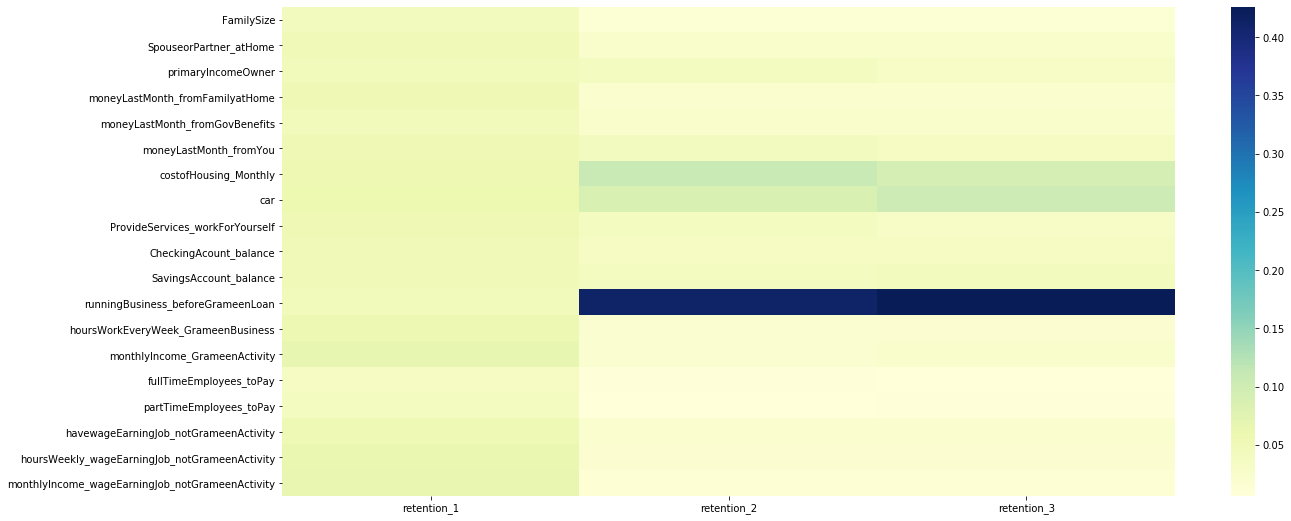

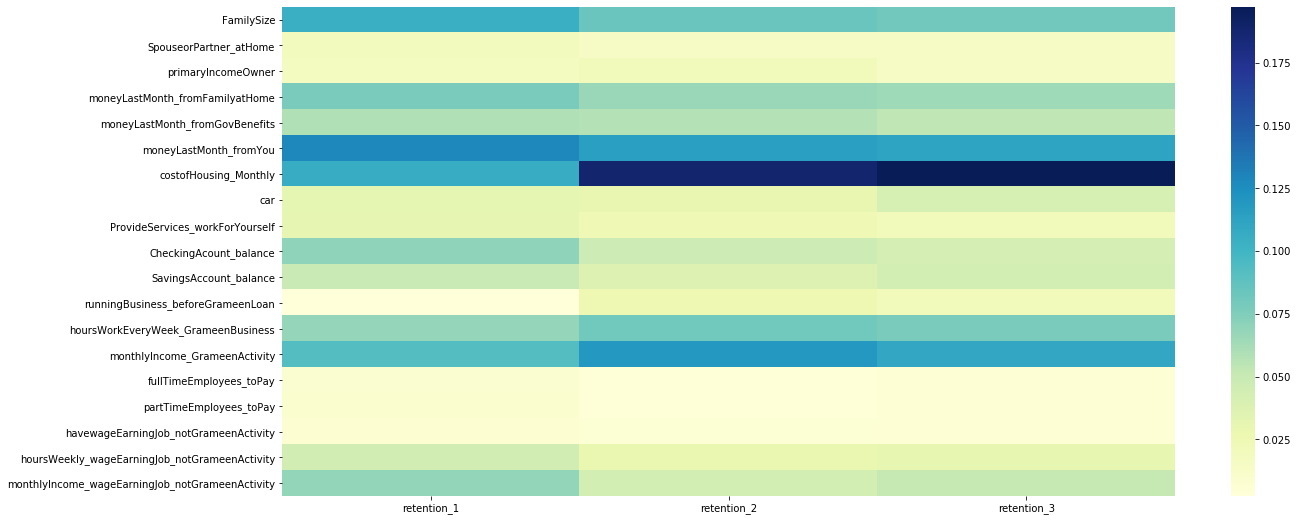

In [8]:
# LASSO Regression
lasso_model = dict()
lasso_results = dict()

# SVM Regression
svm_model = dict()
svm_results = dict()

# Random Forest Regression
rf_model = dict()
rf_results = dict()

# XGBOOST Regression
xgb_model = dict()
xgb_results = dict()

models = ["RF", "XGB"]
# models = ["LASSO","SVM", "RF", "XGB"]
# SVM and LASSO taking a while to work....


for model in models:
    print(model)
    for target in y.columns:
        # create model
        if model == "LASSO":
            reg = LassoCV(cv=3, random_state = SEED)
        elif model == "SVM":
            reg = SVR()
        elif model == "RF":
            reg = RandomForestRegressor(random_state = SEED)
        elif model == "XGB":
            reg = xgb.XGBRegressor(objective ='reg:squarederror', scoring='r2', random_state = SEED)

        # train model
        reg.fit(X_train, y_train[target])
        print(target, "Model Trained")

        # score the model
        train_score = reg.score(X_train, y_train[target])
        test_score = reg.score(X_test, y_test[target])
        print(target, "Model Scored")
        
        # store results
        if model == "LASSO":
            lasso_model[target] = reg
            lasso_results[target] = (train_score, test_score)
        elif model == "SVM":
            svm_model[target] = reg
            svm_results[target] = (train_score, test_score)
        elif model == "RF":
            rf_model[target] = reg
            rf_results[target] = (train_score, test_score)
        elif model == "XGB":
            xgb_model[target] = reg
            xgb_results[target] = (train_score, test_score)
        print(target, "Results Stored")

# gather all results into one data frame
lasso = pd.DataFrame(lasso_results).T
svm = pd.DataFrame(svm_results).T
rf = pd.DataFrame(rf_results).T
xgboost = pd.DataFrame(xgb_results).T

lasso["model"] = "LASSO"
svm["model"] = "SVM"
rf["model"] = "RF"
xgboost["model"] = "XGBoost"
result = lasso.append([svm,rf,xgboost])

feat_imp = [model.feature_importances_ for model in xgb_model.values()]
feat_imp = pd.DataFrame(feat_imp, columns = X.columns)
feat_imp.index = y.columns

plt.figure(figsize=(20,9))
heatmap(feat_imp.T, cmap="YlGnBu")

feat_imp = [model.feature_importances_ for model in rf_model.values()]
feat_imp = pd.DataFrame(feat_imp, columns = X.columns)
feat_imp.index = y.columns

plt.figure(figsize=(20,9))
heatmap(feat_imp.T, cmap="YlGnBu")

plt.savefig("featimp.png")
